In [1]:
# %load_ext autoreload
# %autoreload 2
%matplotlib inline
%load_ext watermark
%watermark -v -m -p numpy,pandas,sklearn,tensorflow -g

import re
import os
import sys
from time import time
import pickle
import pathlib
import itertools
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import swifter
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import watermark

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

np.random.seed(42)

CPython 3.7.3
IPython 7.8.0

numpy 1.17.4
pandas 0.25.1
sklearn 0.21.3
tensorflow 2.0.0

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.0.0
machine    : x86_64
processor  : i386
CPU cores  : 16
interpreter: 64bit
Git hash   : 529455e71c3fbe1904341a957cbe9f1267d1c067


In [2]:
import onnx

model_url = './models/ultralight-RFB-320.onnx'
onnx_model = onnx.load(model_url)
onnx.checker.check_model(onnx_model)

In [12]:
from PIL import Image
import torchvision.transforms as transforms

img = Image.open("./fig/face_alan.jpg")
resize = transforms.Resize([240, 320])
img = resize(img)

# img_ycbcr = img.convert('YCbCr')
# img_y, img_cb, img_cr = img_ycbcr.split()

to_tensor = transforms.ToTensor()
img_y = to_tensor(img)
img_y.unsqueeze_(0)

tensor([[[[0.1020, 0.1020, 0.1059,  ..., 0.1686, 0.1647, 0.1412],
          [0.0941, 0.0941, 0.0980,  ..., 0.1490, 0.1569, 0.1294],
          [0.0784, 0.0941, 0.1137,  ..., 0.1412, 0.1451, 0.1294],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0863, 0.0706, 0.0784],
          [0.0000, 0.0000, 0.0000,  ..., 0.0667, 0.0588, 0.0588],
          [0.0000, 0.0000, 0.0000,  ..., 0.0902, 0.0902, 0.1020]],

         [[0.2275, 0.2275, 0.2314,  ..., 0.2941, 0.2863, 0.2941],
          [0.2196, 0.2196, 0.2235,  ..., 0.2784, 0.2784, 0.2784],
          [0.2039, 0.2196, 0.2392,  ..., 0.2667, 0.2745, 0.2863],
          ...,
          [0.0078, 0.0078, 0.0078,  ..., 0.2039, 0.2000, 0.2078],
          [0.0118, 0.0118, 0.0118,  ..., 0.2118, 0.2157, 0.2157],
          [0.0118, 0.0118, 0.0118,  ..., 0.2196, 0.2157, 0.2275]],

         [[0.3098, 0.3098, 0.3137,  ..., 0.3529, 0.3490, 0.3451],
          [0.3020, 0.3020, 0.3059,  ..., 0.3451, 0.3529, 0.3412],
          [0.2863, 0.3020, 0.3216,  ..., 0

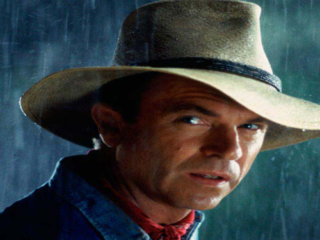

In [13]:
img

In [14]:
img_y.shape

torch.Size([1, 3, 240, 320])

In [15]:
import onnxruntime

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

ort_session = onnxruntime.InferenceSession(model_url)
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img_y)}
ort_outs = ort_session.run(None, ort_inputs)
img_out_y = ort_outs[0]

In [16]:
img_out_y.shape

(1, 4420, 2)

In [37]:
[ind for ind,k in enumerate(img_out_y[0][:,1]) if k > 0.5]

[4291, 4293, 4311, 4313, 4396, 4397, 4399, 4400]

In [38]:
img_out_y[0][[4291, 4293, 4311, 4313, 4396, 4397, 4399, 4400],1].tolist()

[0.8939735293388367,
 0.8505003452301025,
 0.8851299285888672,
 0.7441688776016235,
 0.9981738328933716,
 0.9717711210250854,
 0.9740408062934875,
 0.8554111123085022]

In [46]:


img_out_y = Image.fromarray(np.uint8((img_out_y[0] * 255.0).clip(0, 255)[0]), mode='L')

# get the output image follow post-processing step from PyTorch implementation
final_img = Image.merge(
    "YCbCr", [
        img_out_y,
        img_cb.resize(img_out_y.size, Image.BICUBIC),
        img_cr.resize(img_out_y.size, Image.BICUBIC),
    ]).convert("RGB")

# Save the image, we will compare this with the output image from mobile device
final_img.save("./_static/img/cat_superres_with_ort.jpg")

IndexError: tuple index out of range

In [2]:
import torch
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR, MultiStepLR
from torch.utils.data import DataLoader, ConcatDataset

from vision.datasets.voc_dataset import VOCDataset
from vision.nn.multibox_loss import MultiboxLoss
from vision.ssd.config.fd_config import define_img_size
from vision.utils.misc import str2bool, Timer, freeze_net_layers, store_labels

ModuleNotFoundError: No module named 'vision'

In [3]:
# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

NameError: name 'x' is not defined